# baseline
In this experiment, we will create two baseline machine learning models to predict the values, providing a foundation for future iterations.
Now that we have everything ready, we will export the dataset.

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
import nltk
import torch
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Custom imports
from helper.helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)


# ml versioning control
import dagshub
dagshub.init(repo_owner='auszed', repo_name='my-first-repo', mlflow=True)

# Enable code block
enable_code = False

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
y_val = pd.read_csv("dataset/y_val.csv")
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv")

print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )

theme_color

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(26759, 39) (26759, 1)
(5734, 39) (5734, 1)
(5735, 39) (5735, 1)


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [81]:
X_train.drop(["title", "text"], axis=1, inplace=True)
X_val.drop(["title", "text"], axis=1, inplace=True)
X_test.drop(["title", "text"], axis=1, inplace=True)

X_train.sample(5)

,subject,date,is_twitter_handle,is_reuters,title_count_each_word,title_count_unique_word,title_count_punctuations,title_count_words_title,title_count_stopwords,title_mean_word_len,...,text_new_line,text_new_small_space,text_new_medium_space,text_new_big_space,text_uppercase_words,text_question_mark,text_exclamation_mark,text_word_unique_percent,text_punctuations_percent,title_text_join
11213,worldnews,2017-09-22,False,True,6,6,1,2,0,7.000000,...,0,0,0,0,582,0,0,49.082969,11.091703,Post election conundrum awaits Germany's Merke...
18604,politicsNews,2016-02-29,False,True,9,8,1,4,4,5.222222,...,0,0,0,0,184,1,0,55.606936,10.289017,Super Tuesday showdown: How the South won the ...
25587,politics,2016-10-29,False,False,14,13,1,8,5,5.571429,...,0,0,0,0,72,0,0,56.834532,8.633094,BREAKING: DEVICE THAT BUSTED HILLARY CLINTON D...
15413,politicsNews,2016-05-24,False,True,10,10,3,2,1,5.500000,...,0,0,0,0,64,0,0,62.730627,7.011070,Ohio violated voting rights by reducing early ...
15297,News,2016-03-16,False,False,14,14,0,13,1,5.642857,...,0,0,0,0,103,1,0,57.534247,8.675799,Georgia Republican Ruthlessly Blocks Rape Kit...


We will remove some columns that we think couldn’t impact the results of the model:

- date
- title_count_unique_word
- title_count_punctuations
- title_count_words_title
- title_count_stopwords
- title_mean_word_len
- title_total_length
- title_new_line
- title_new_small_space
- title_new_medium_space
- title_new_big_space
- title_uppercase_words
- title_question_mark
- title_exclamation_mark
- title_word_unique_percent
- title_punctuations_percent
- text_count_unique_word
- text_count_punctuations
- text_count_words_title
- text_count_stopwords
- text_mean_word_len
- text_total_length
- text_new_line
- text_new_small_space
- text_new_medium_space
- text_new_big_space
- text_uppercase_words
- text_question_mark
- text_exclamation_mark
- text_word_unique_percent
- text_punctuations_percent


In [82]:
X_train = X_train[['subject', 'is_twitter_handle', 'is_reuters', 'title_count_each_word', 'text_count_each_word', 'title_text_join']]
X_val = X_val[['subject', 'is_twitter_handle', 'is_reuters', 'title_count_each_word', 'text_count_each_word', 'title_text_join']]
X_test = X_test[['subject', 'is_twitter_handle', 'is_reuters', 'title_count_each_word', 'text_count_each_word', 'title_text_join']]
X_train.sample()

,subject,is_twitter_handle,is_reuters,title_count_each_word,text_count_each_word,title_text_join
22002,politics,False,False,9,1150,SHOCKING VIDEO: Baltimore Baseball Fans Fight ...


# Metrics
We will use the F1 score as the primary performance metric for both machine learning algorithms and deep learning models. This allows us to compare their performance consistently.

# Preprocess pipeline
We will start with a Naive bayes model 

In [83]:
# Define transformations for each column
text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english'))  
])
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), 
    ("scaler", StandardScaler())  
])
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  
])
binary_pipeline = Pipeline([
    ("binary_to_int", FunctionTransformer(lambda x: x.astype(int)))  # Convert True/False to 1/0
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join"),
        ("numeric", numeric_pipeline, ["title_count_each_word", "text_count_each_word"]),
        ("categorical", categorical_pipeline, ["subject"]),
        ("binary", binary_pipeline, ["is_twitter_handle", "is_reuters"]) 
    ]
)
preprocessor

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'title_text_join'),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['title_count_each_word',
                                  'text_count_each_word']),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['subject']),
                                ('binary',
                                 Pipeline(steps=[('binary_to_int',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000019293A6B1A0>))]),
                                 ['is_twitter_handle', 'is_reuters'])])

# Models
We will start we the baseline models so we can see how the model performs in this environment.

## Experiment 1
We will use a logistic regression and a random forest for the baseline model so we can see how it performs.

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'text_count_each_word']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['subject']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000019293A6B1A0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', LogisticRegression())])

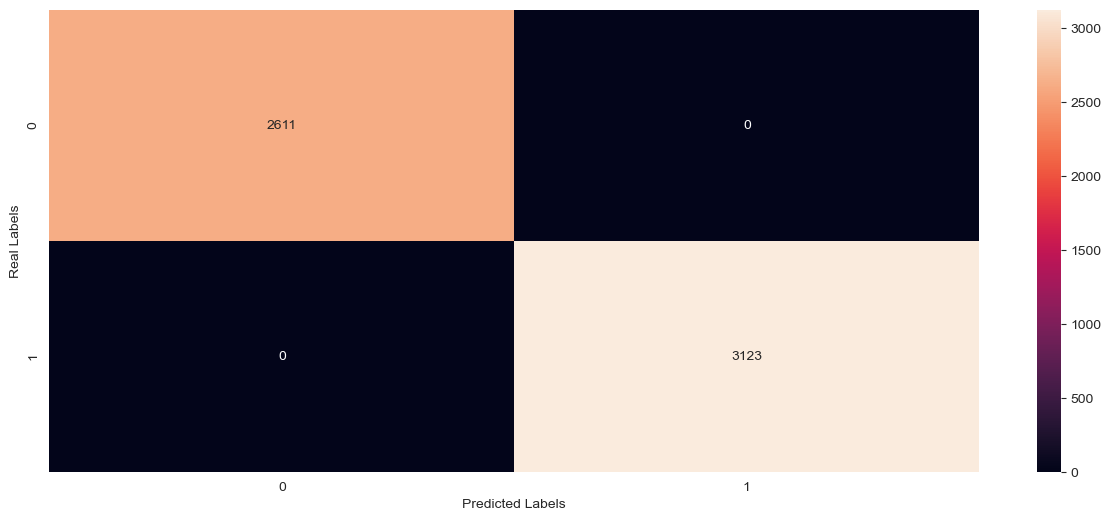

In [84]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression()) 
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='' )
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

Here we had a perfect score, so we need to give it a look whats happening.

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'text_count_each_word']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['subject']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000019293A6B1A0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', RandomForestClassifier(n_estimators=300))])

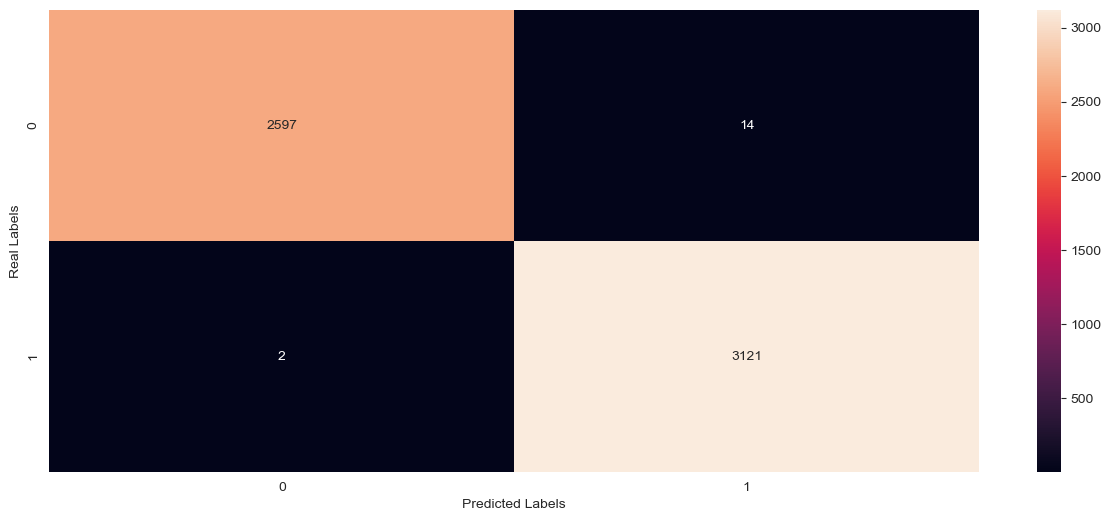

In [85]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300))  
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

In this case kind of happens the same, so we need to check the data again.
## Experiment 2, Heuristic

after looking the dataset we will try to take out some features from the datasets so it can generalize better,
because when we do the EDA seems that some features can had a lot of predictability.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'text_count_each_word']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['subject']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000019293A6B1A0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', RandomForestClassifier(n_estimators=300))])

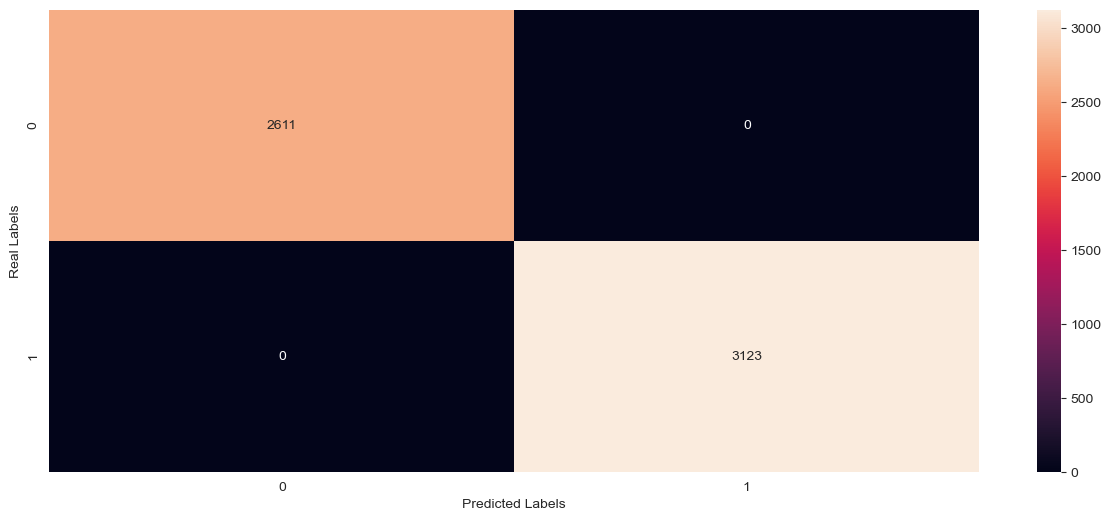

In [86]:
# List append
def prediction_heuristic(column):
    prediction_X = []
    for subject in column:
        if subject in ["worldnews", "politicsNews"]:
            prediction_X.append(1)
        else:
            prediction_X.append(0)
            
    return prediction_X

y_pred = prediction_heuristic(X_val["subject"])
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

Just by using the heuristic we can detect the correct class,
so we will try
to take out those features that can impact the results for now we will take just the subject to see
if we got a more accrued result.

## Experiment 3

In [87]:
X_train = pd.read_csv("dataset/X_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
X_test = pd.read_csv("dataset/X_test.csv")

X_train =X_train.drop(columns= ["title", "text", "subject", "date", "title_new_line", "title_new_small_space", "title_new_medium_space", "title_new_big_space",
                                "text_new_line", "text_new_small_space", "text_new_medium_space", "text_new_big_space"])
X_val = X_val.drop(columns= ["title", "text", "subject", "date", "title_new_line", "title_new_small_space", "title_new_medium_space", "title_new_big_space",
                             "text_new_line", "text_new_small_space", "text_new_medium_space", "text_new_big_space"])
X_test = X_test.drop(columns= ["title", "text", "subject", "date", "title_new_line", "title_new_small_space", "title_new_medium_space", "title_new_big_space",
                               "text_new_line", "text_new_small_space", "text_new_medium_space", "text_new_big_space"])

X_train.nunique()

is_twitter_handle                 2
is_reuters                        2
title_count_each_word            40
title_count_unique_word          38
title_count_punctuations          9
title_count_words_title          33
title_count_stopwords            19
title_mean_word_len             746
title_total_length              202
title_uppercase_words           106
title_question_mark               4
title_exclamation_mark            4
title_word_unique_percent        77
title_punctuations_percent      129
text_count_each_word           1480
text_count_unique_word          842
text_count_punctuations         306
text_count_words_title          382
text_count_stopwords            757
text_mean_word_len            20585
text_total_length              6144
text_uppercase_words            548
text_question_mark               32
text_exclamation_mark            24
text_word_unique_percent      13672
text_punctuations_percent     10079
title_text_join               26759
dtype: int64

Now we preprocess the pipeline again.

In [88]:
X_train.dtypes

is_twitter_handle                bool
is_reuters                       bool
title_count_each_word           int64
title_count_unique_word         int64
title_count_punctuations        int64
title_count_words_title         int64
title_count_stopwords           int64
title_mean_word_len           float64
title_total_length              int64
title_uppercase_words           int64
title_question_mark             int64
title_exclamation_mark          int64
title_word_unique_percent     float64
title_punctuations_percent    float64
text_count_each_word            int64
text_count_unique_word          int64
text_count_punctuations         int64
text_count_words_title          int64
text_count_stopwords            int64
text_mean_word_len            float64
text_total_length               int64
text_uppercase_words            int64
text_question_mark              int64
text_exclamation_mark           int64
text_word_unique_percent      float64
text_punctuations_percent     float64
title_text_j

In [89]:
numeric_pipeline_values = ["title_count_each_word", "title_count_unique_word", "title_count_punctuations", "title_count_words_title", "title_count_stopwords", "title_mean_word_len", "title_total_length", "title_uppercase_words", "title_question_mark", "title_exclamation_mark", "title_word_unique_percent", "title_punctuations_percent", "text_count_each_word", "text_count_unique_word", "text_count_punctuations", "text_count_words_title", "text_count_stopwords", "text_mean_word_len", "text_total_length", "text_uppercase_words", "text_question_mark", "text_exclamation_mark", "text_word_unique_percent", "text_punctuations_percent"]


preprocessor_2 = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join"),
        ("numeric", numeric_pipeline, numeric_pipeline_values),
        ("binary", binary_pipeline, ["is_twitter_handle", "is_reuters"]) 
    ]
)
preprocessor_2

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'title_text_join'),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['title_count_each_word',
                                  'title_count_unique_word',
                                  'title_count_punctuations',
                                  'title_count_words_title',
                                  'title_count_stopwords',
                                  'title_mean_...
                                  'text_count_words_title',
                                  'text_count_stopwords', 'text_mean_word_len',
                                  'text_total_length', 'text_uppercase_words',
                                  'text_question_mark', 'text_exclamation_mark',
                                  'text_word_unique_percent',
                                  'text_punctuations_percent']),
                                ('binary',
                                 Pipeline(steps=[('binary_to_int',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000019293A6B1A0>))]),
                                 ['is_twitter_handle', 'is_reuters'])])

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'title_count_unique_word',
                                                   'title_count_punctuations',
                                                   'title_count_words_title',
                                                   'tit...
                                                   'text_mean_word_len',
                                                   'text_total_length',
                                                   'text_uppercase_words',
                                                   'text_question_mark',
                                                   'text_exclamation_mark',
                                                   'text_word_unique_percent',
                                                   'text_punctuations_percent']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000019293A6B1A0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', LogisticRegression())])

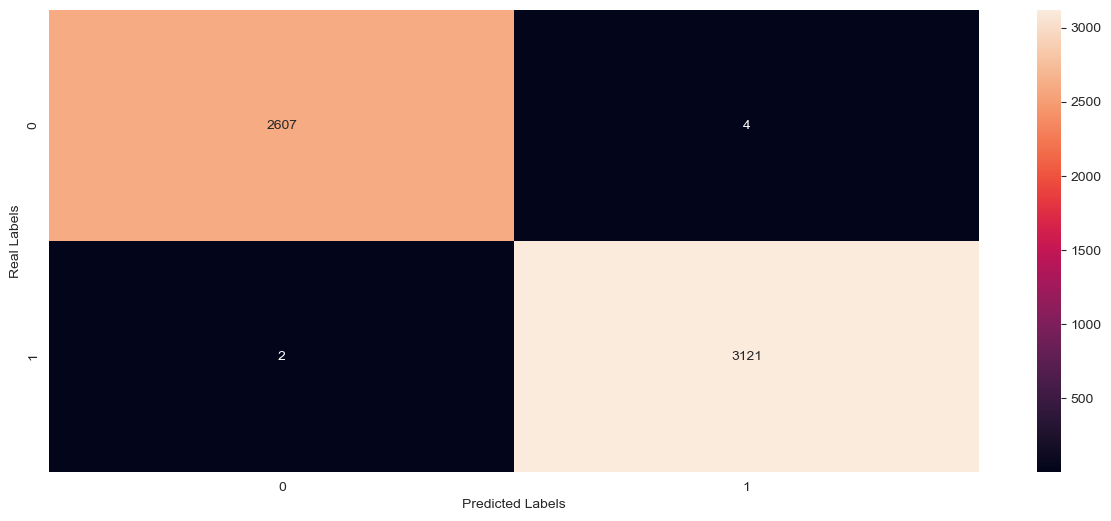

In [90]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor_2),
    ("classifier", LogisticRegression()) 
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='' )
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

Seems that the model still predicting the same,
so we will try
to take out the Reuters and twitter handle to see if we could handle a correct performance for the baseline.

In [91]:
X_train =X_train.drop(columns= ["is_twitter_handle", "is_reuters", ])
X_val = X_val.drop(columns= ["is_twitter_handle", "is_reuters", ])
X_test = X_test.drop(columns= ["is_twitter_handle", "is_reuters", ])

preprocessor_3 = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join"),
        ("numeric", numeric_pipeline, numeric_pipeline_values)
    ]
)
preprocessor_3

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'title_text_join'),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['title_count_each_word',
                                  'title_count_unique_word',
                                  'title_count_punctuations',
                                  'title_count_words_title',
                                  'title_count_stopwords',
                                  'title_mean_...
                                  'title_exclamation_mark',
                                  'title_word_unique_percent',
                                  'title_punctuations_percent',
                                  'text_count_each_word',
                                  'text_count_unique_word',
                                  'text_count_punctuations',
                                  'text_count_words_title',
                                  'text_count_stopwords', 'text_mean_word_len',
                                  'text_total_length', 'text_uppercase_words',
                                  'text_question_mark', 'text_exclamation_mark',
                                  'text_word_unique_percent',
                                  'text_punctuations_percent'])])

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'title_count_unique_word',
                                                   'title_count_punctuations',
                                                   'title_count_words_title',
                                                   'tit...
                                                   'title_punctuations_percent',
                                                   'text_count_each_word',
                                                   'text_count_unique_word',
                                                   'text_count_punctuations',
                                                   'text_count_words_title',
                                                   'text_count_stopwords',
                                                   'text_mean_word_len',
                                                   'text_total_length',
                                                   'text_uppercase_words',
                                                   'text_question_mark',
                                                   'text_exclamation_mark',
                                                   'text_word_unique_percent',
                                                   'text_punctuations_percent'])])),
                ('classifier', LogisticRegression())])

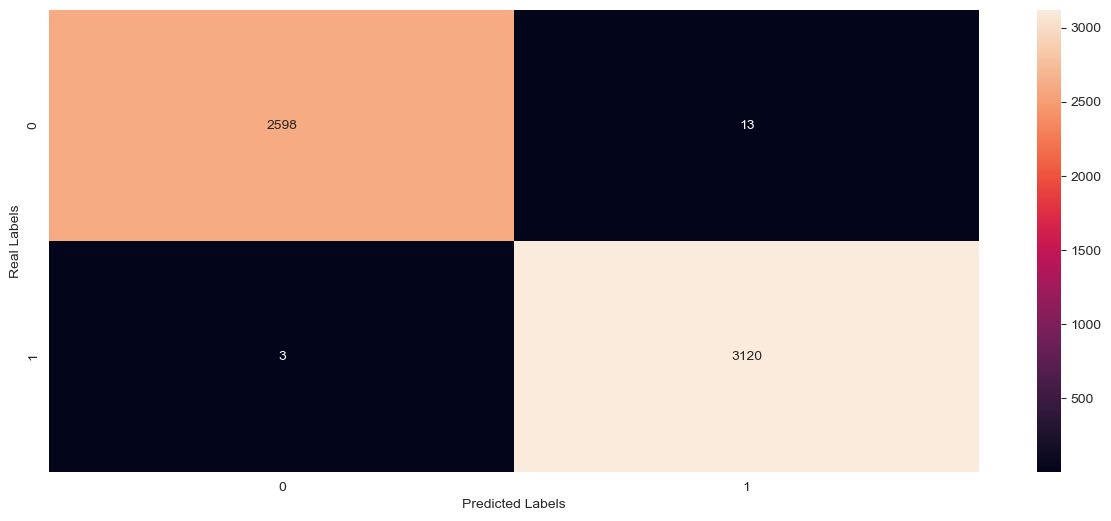

In [92]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor_3),
    ("classifier", LogisticRegression()) 
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='' )
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

Seems that i still got the same results, i will take out also the Reuters and twitter words from the final dataset.

In [93]:
def clean_text(text):
    """Delete the Reuters and the twitter handle"""
    text = re.sub(r'\bReuters\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'VIDEO', '', text)
    text = re.sub(r'VIDEOS', '', text)
    text = re.sub(r'TWEETS', '', text)
    text = re.sub(r'IMAGE', '', text)
    text = re.sub(r'IMAGES', '', text)
    text = re.sub(r'AUDIO', '', text)
    text = text.strip()
    return text

X_train = X_train[['title_text_join']]
X_val = X_val[['title_text_join']]
X_test = X_test[['title_text_join']]

X_train["title_text_join"] = X_train["title_text_join"].apply(clean_text)
X_val["title_text_join"] = X_val["title_text_join"].apply(clean_text)
X_test["title_text_join"] = X_test["title_text_join"].apply(clean_text)
X_train.sample(2)

,title_text_join
12564,Trump Stands Up For Fellow Sexual Harasser Bil...
854,Palin Blames Son’s Domestic Violence Arrest On...


C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2611
           1       0.97      0.98      0.98      3123

    accuracy                           0.98      5734
   macro avg       0.98      0.97      0.98      5734
weighted avg       0.98      0.98      0.98      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join')])),
                ('classifier', LogisticRegression())])

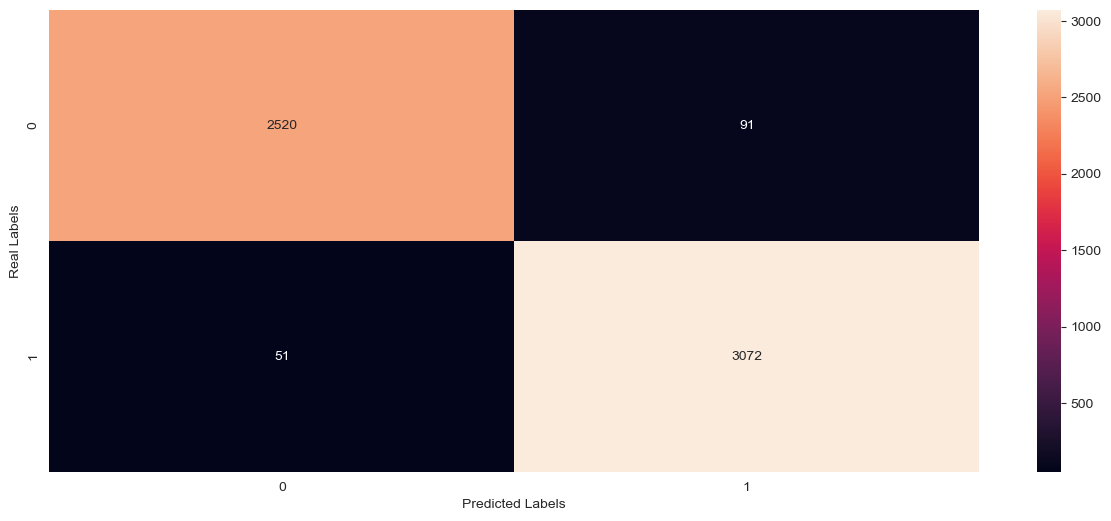

In [94]:
preprocessor_4 = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join")
    ]
)

model_pipeline = Pipeline([
    ("preprocessor", preprocessor_4),
    ("classifier", LogisticRegression()) 
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='' )
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

In [95]:
title = "Scientists Discover Alien Life on Mars"
text = "In a groundbreaking revelation, a team of international scientists announced today that they have discovered evidence of intelligent alien life on Mars. The discovery reportedly includes structures resembling ancient buildings, inscriptions in an unknown language, and traces of advanced technology buried beneath the Martian soil. According to Dr. Liza Carter, lead researcher at the Mars Exploration Institute, This finding will redefine humanity's understanding of the universe and our place within it. Social media is abuzz with theories, ranging from peaceful extraterrestrial civilizations to potential interplanetary conflicts. However, some experts caution that these claims lack solid evidence and may be part of an elaborate hoax. Stay tuned for further updates on this developing story!"

comment_example = pd.DataFrame({"title_text_join": [title + " " + text]})
# prediction = model_pipeline.predict(comment_example)
prediction = model_pipeline.predict(comment_example)
prediction

array([0], dtype=int64)

In [96]:

X_train.to_csv("dataset/X_train_processed.csv", index=False)
X_val.to_csv("dataset/X_val_processed.csv", index=False)
X_test.to_csv("dataset/X_test_processed.csv", index=False)

In [103]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('punkt')

def count_words(text):
    # Tokenize the text
    words = word_tokenize(text.lower())  # Convert to lowercase for case-insensitive counting
    # Calculate word frequencies
    word_freq = FreqDist(words)
    return word_freq

X_testassda = X_test.copy()
X_testassda["we"] = X_testassda["title_text_join"].apply(count_words)


for index, row in X_testassda.iterrows():
    print(f"Text: {row['text']}\nWord Counts: {row['we']}\n")

X_testassda

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\hanns/nltk_data'
    - 'C:\\Users\\hanns\\anaconda3\\envs\\nlp\\nltk_data'
    - 'C:\\Users\\hanns\\anaconda3\\envs\\nlp\\share\\nltk_data'
    - 'C:\\Users\\hanns\\anaconda3\\envs\\nlp\\lib\\nltk_data'
    - 'C:\\Users\\hanns\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


# Conclusions

